In [0]:
import pandas as pd
import numpy as np

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Data Preperation

In [0]:
import scipy.stats as sps
from scipy.stats import zscore

In [0]:
finaldf=pd.read_csv('/content/drive/Shared drives/DSO562 Fraud Project/Project2/candidates_v2.csv')

In [0]:
mydata=finaldf[finaldf['date']>"2016-01-14"].copy()

In [0]:
mydatacopy=mydata.copy()

In [0]:
mydata=mydata.drop(columns=['Unnamed: 0','record','date'])

In [0]:
mydata['address_days_since_last_seen']

38511       0.0
38512       0.0
38513       0.0
38514       0.0
38515       0.0
          ...  
999995      0.0
999996      0.0
999997      0.0
999998      0.0
999999    319.0
Name: address_days_since_last_seen, Length: 961489, dtype: float64

In [0]:
mydata['fulladdress_days_since_last_seen']

38511       0.0
38512       0.0
38513       0.0
38514       0.0
38515       0.0
          ...  
999995      0.0
999996      0.0
999997      0.0
999998      0.0
999999    319.0
Name: fulladdress_days_since_last_seen, Length: 961489, dtype: float64

In [0]:
mydata['random']=np.random.uniform(size = len(mydata))

In [0]:
import scipy.stats as sps
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


In [0]:
scaled_data = scaler.fit_transform(mydata)

In [0]:
names = mydata.columns
scaled_data=pd.DataFrame(scaled_data, columns=names)

In [0]:
scaled_data['ssnfname_nunique3_ssn'].describe()

count    961489.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: ssnfname_nunique3_ssn, dtype: float64

In [0]:
zmydata=scaled_data

In [0]:
zmydata.isna()

,fraud_label,ssn_count0_date,ssn_count1_date,ssn_count3_date,ssn_count7_date,ssn_count14_date,ssn_count30_date,ssn_count180_date,address_count0_date,address_count1_date,address_count3_date,address_count7_date,address_count14_date,address_count30_date,address_count180_date,dob_count0_date,dob_count1_date,dob_count3_date,dob_count7_date,dob_count14_date,dob_count30_date,dob_count180_date,homephone_count0_date,homephone_count1_date,homephone_count3_date,homephone_count7_date,homephone_count14_date,homephone_count30_date,homephone_count180_date,namedob_count0_date,namedob_count1_date,namedob_count3_date,namedob_count7_date,namedob_count14_date,namedob_count30_date,namedob_count180_date,fulladdress_count0_date,fulladdress_count1_date,fulladdress_count3_date,fulladdress_count7_date,...,dob_nunique1_ssn,dob_nunique1_homephone,dob_nunique1_ssnfname,dob_nunique1_fulladdress,dob_nunique3_ssn,dob_nunique3_homephone,dob_nunique3_ssnfname,dob_nunique3_fulladdress,fulladdress_nunique1_ssn,fulladdress_nunique1_homephone,fulladdress_nunique1_ssnfname,fulladdress_nunique1_dob,fulladdress_nunique3_ssn,fulladdress_nunique3_homephone,fulladdress_nunique3_ssnfname,fulladdress_nunique3_dob,ssn_days_since_last_seen,address_days_since_last_seen,dob_days_since_last_seen,homephone_days_since_last_seen,namedob_days_since_last_seen,fulladdress_days_since_last_seen,ssnfname_days_since_last_seen,ssnlname_days_since_last_seen,ssnfullname_days_since_last_seen,ssnaddress_days_since_last_seen,ssnzip5_days_since_last_seen,ssndob_days_since_last_seen,ssnhomephone_days_since_last_seen,ssnnamedob_days_since_last_seen,ssnfulladdress_days_since_last_seen,namehomephone_days_since_last_seen,namefulladdress_days_since_last_seen,fulladdressdob_days_since_last_seen,fulladdresshomephone_days_since_last_seen,fulladdressnamedob_days_since_last_seen,dobhomephone_days_since_last_seen,homephonenamedob_days_since_last_seen,dayofweek_risk,random
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,F

In [0]:
zmydata['date']=mydatacopy['date'].values
zmydata['fraud_label']=mydata['fraud_label'].values

In [0]:
zmydata['fraud_label'].sum()

13872

In [0]:
zmydatatest=zmydata[zmydata['date']>"2016-10-31"]
zmydatatest=zmydatatest.drop(columns=['date'])

In [0]:
zmydatatrain=zmydata[zmydata['date']<="2016-10-31"]
zmydatatrain=zmydatatrain.drop(columns=['date'])

In [0]:
zmydatatrain['ssnfname_nunique3_ssn'].describe()

count    794996.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: ssnfname_nunique3_ssn, dtype: float64

In [0]:
goodscopy=zmydatatrain[zmydatatrain['fraud_label']==0].copy()
badscopy=zmydatatrain[zmydatatrain['fraud_label']==1].copy()

In [0]:
collist=zmydatatrain.columns.tolist()

In [0]:
sps.ks_2samp(goodscopy['ssn_count0_date'],badscopy['ssn_count0_date'])[0]

0.10709290590090792

In [0]:
i=0
KSFDR=[]
for column in collist:
    KSFDR.append(sps.ks_2samp(goodscopy[column],badscopy[column])[0])
    i=i+1

In [0]:
KSFDR=pd.DataFrame(KSFDR,columns=['ks'])

In [0]:
KSFDR

,ks
0,1.000000
1,0.107093
2,0.148704
3,0.172102
4,0.193036
...,...
302,0.058663
303,0.060210
304,0.058460
305,0.022088


In [0]:
topRows = int(round(len(zmydatatrain)*0.03))
j = 0
numbads=sum(zmydatatrain['fraud_label']==1)
temp0=pd.DataFrame()
for column in zmydatatrain:
    if column=='fraud_label':
        temp0['fraud_label'] = zmydatatrain['fraud_label']
        temp0['fraud_label2']=zmydatatrain['fraud_label']
    else:
        temp0 = zmydatatrain[[column,'fraud_label']].copy()
    temp1 = temp0.sort_values(column,ascending=False).head(topRows).copy()
    temp2 = temp0.sort_values(column,ascending=True).head(topRows).copy()
    needed1 = temp1.loc[:,'fraud_label']
    needed2 = temp2.loc[:,'fraud_label']
    FDR1 = sum(needed1)/numbads
    FDR2 = sum(needed2)/numbads
    FDRate = np.maximum(FDR1,FDR2)
    KSFDR.loc[j, 'FDR'] = FDRate
    j = j +1


In [0]:
KSFDR

,ks,FDR
0,1.000000,1.000000
1,0.107093,0.134947
2,0.148704,0.175431
3,0.172102,0.198328
4,0.193036,0.218614
...,...,...
302,0.058663,0.082971
303,0.060210,0.086627
304,0.058460,0.083928
305,0.022088,0.033780


In [0]:
numbads

11486

In [0]:
KSFDR['rank_ks'] = KSFDR['ks'].rank(ascending = True)
KSFDR['rank_FDR'] = KSFDR['FDR'].rank(ascending = True)

In [0]:
KSFDR['average_rank'] = (KSFDR['rank_ks'] + KSFDR['rank_FDR']) / 2
KSFDR.sort_values(by=['average_rank'], ascending=False, inplace=True)

In [0]:
KSFDR
newKSFDR=KSFDR.reset_index()
newKSFDR

,index,ks,FDR,rank_ks,rank_FDR,average_rank
0,0,1.000000,1.000000,307.0,307.0,307.00
1,288,0.333210,0.358349,305.0,306.0,305.50
2,284,0.334096,0.355128,306.0,305.0,305.50
3,41,0.332032,0.354954,303.0,304.0,303.50
4,13,0.332725,0.353300,304.0,303.0,303.50
...,...,...,...,...,...,...
302,249,0.000128,0.033084,8.0,3.0,5.50
303,265,0.000103,0.033258,4.0,5.5,4.75
304,244,0.000015,0.033258,3.0,5.5,4.25
305,259,-0.000000,0.033084,1.5,3.0,2.25


In [0]:
matchcolumn=pd.DataFrame(collist)
matchcolumn=matchcolumn.reset_index()
matchcolumn=matchcolumn.rename(columns={0: 'VariableName'})
matchcolumn

,index,VariableName
0,0,fraud_label
1,1,ssn_count0_date
2,2,ssn_count1_date
3,3,ssn_count3_date
4,4,ssn_count7_date
...,...,...
302,302,fulladdressnamedob_days_since_last_seen
303,303,dobhomephone_days_since_last_seen
304,304,homephonenamedob_days_since_last_seen
305,305,dayofweek_risk


In [0]:
newKSFDR = pd.merge(matchcolumn, newKSFDR, left_on = ['index'], right_on = ['index'],how='right')

In [0]:
newKSFDR=newKSFDR.sort_values('average_rank',ascending=False)
newKSFDR=newKSFDR.drop(columns=['index'])

In [0]:
newKSFDR

,VariableName,ks,FDR,rank_ks,rank_FDR,average_rank
0,fraud_label,1.000000,1.000000,307.0,307.0,307.00
288,fulladdress_days_since_last_seen,0.333210,0.358349,305.0,306.0,305.50
284,address_days_since_last_seen,0.334096,0.355128,306.0,305.0,305.50
41,fulladdress_count30_date,0.332032,0.354954,303.0,304.0,303.50
13,address_count30_date,0.332725,0.353300,304.0,303.0,303.50
...,...,...,...,...,...,...
249,ssn_nunique3_dob,0.000128,0.033084,8.0,3.0,5.50
265,ssnfname_nunique3_dob,0.000103,0.033258,4.0,5.5,4.75
244,ssn_nunique1_ssnfname,0.000015,0.033258,3.0,5.5,4.25
259,ssnfname_nunique1_ssn,-0.000000,0.033084,1.5,3.0,2.25


In [0]:
newKSFDR.to_csv('homework6_0302.csv')

In [0]:
vars_keep=newKSFDR['VariableName'][1:55].to_list()

In [0]:
zmydatatrain[vars_keep]

,fulladdress_days_since_last_seen,address_days_since_last_seen,fulladdress_count30_date,address_count30_date,address_count14_date,address_count180_date,fulladdress_count14_date,fulladdress_count180_date,address_count7_date,fulladdress_count7_date,fulladdress_count3_date,address_count3_date,fulladdress_nunique3_ssn,fulladdress_nunique3_ssnfname,fulladdress_nunique3_dob,address_count1_date,fulladdress_count1_date,fulladdress_nunique1_dob,fulladdress_nunique1_ssn,fulladdress_nunique1_ssnfname,fulladdresshomephone_days_since_last_seen,fulladdresshomephone_count30_date,ssndob_days_since_last_seen,ssndob_count30_date,namedob_count30_date,namedob_days_since_last_seen,ssn_days_since_last_seen,ssn_count30_date,ssnfname_days_since_last_seen,ssnnamedob_days_since_last_seen,ssnlname_days_since_last_seen,ssnnamedob_count30_date,ssnfname_count30_date,ssnlname_count30_date,ssnfullname_days_since_last_seen,ssnfullname_count30_date,ssndob_count180_date,namedob_count180_date,ssn_count180_date,fulladdresshomephone_count180_date,fulladdresshomephone_count14_date,ssnlname_count180_date,ssnfname_count180_date,ssnnamedob_count180_date,ssnfullname_count180_date,namedob_count14_date,ssndob_count14_date,ssn_count14_date,ssnnamedob_count14_date,ssnfname_count14_date,ssnlname_count14_date,ssnfullname_count14_date,address_1_count_address_14_count_Ave,fulladdress_1_count_fulladdress_14_count_Ave
0,-0.411706,-0.437425,-0.103392,-0.119479,-0.089339,-0.214284,-0.079681,-0.227749,-0.073005,-0.067413,-0.058171,-0.061071,-0.052073,-0.052086,-0.052572,-0.051332,-0.049913,-0.047263,-0.047001,-0.047011,-0.384043,-0.096485,-0.374468,-0.09434,-0.094632,-0.375653,-0.400721,-0.100589,-0.398333,-0.373585,-0.398269,-0.094045,-0.099596,-0.099584,-0.397608,-0.099366,-0.218006,-0.217501,-0.189519,-0.222642,-0.070856,-0.234407,-0.234458,-0.217328,-0.233941,-0.069169,-0.068978,-0.073065,-0.068841,-0.071707,-0.07167,-0.071577,0.141748,0.125036
1,-0.411706,-0.437425,-0.103392,-0.119479,-0.089339,-0.214284,-0.079681,-0.227749,-0.073005,-0.067413,-0.058171,-0.061071,-0.052073,-0.052086,-0.052572,-0.051332,-0.049913,-0.047263,-0.047001,-0.047011,-0.384043,-0.096485,-0.374468,-0.09434,-0.094632,-0.375653,-0.400721,-0.100589,-0.398333,-0.373585,-0.398269,-0.094045,-0.099596,-0.099584,-0.397608,-0.099366,-0.218006,-0.217501,-0.189519,-0.222642,-0.070856,-0.234407,-0.234458,-0.217328,-0.233941,-0.069169,-0.068978,-0.073065,-0.068841,-0.071707,-0.07167,-0.071577,0.141748,0.125036
2,-0.411706,-0.437425,-0.103392,-0.119479,-0.089339,-0.214284,-0.079681,-0.227749,-0.073005,-0.067413,-0.058171,-0.061071,-0.052073,-0.052086,-0.052572,-0.051332,-0.049913,-0.047263,-0.047001,-0.047011,-0.384043,-0.096485,-0.374468,-0.09434,-0.094632,-0.375653,-0.400721,-0.100589,-0.398333,-0.373585,-0.398269,-0.094045,-0.099596,-0.099584,-0.397608,-0.099366,-0.218006,-0.217501,-0.189519,-0.222642,-0.070856,-0.234407,-0.234458,-0.217328,-0.233941,-0.069169,-0.068978,-0.073065,-0.068841,-0.071707,-0.07167,-0.071577,0.141748,0.125036
3,-0.411706,-0.437425,-0.103392,-0.119479,-0.089339,-0.214284,-0.079681,-0.227749,-0.073005,-0.067413,-0.058171,-0.061071,-0.052073,-0.052086,-0.052572,-0.051332,-0.049913,-0.047263,-0.047001,-0.047011,-0.384043,-0.096485,-0.374468,-0.09434,-0.094632,-0.375653,-0.400721,-0.100589,-0.398333,-0.373585,-0.398269,-0.094045,-0.099596,-0.099584,-0.397608,-0.099366,-0.218006,-0.217501,-0.189519,-0.222642,-0.070856,-0.234407,-0.234458,-0.217328,-0.233941,-0.069169,-0.068978,-0.073065,-0.068841,-0.071707,-0.07167,-0.071577,0.141748,0.125036
4,-0.411706,-0.437425,-0.103392,-0.119479,-0.089339,-0.214284,-0.079681,-0.227749,-0.073005,-0.067413,-0.058171,-0.061071,-0.052073,-0.052086,-0.052572,-0.051332,-0.049913,-0.047263,-0.047001,-0.047011,-0.384043,-0.096485,-0.374468,-0.09434,-0.094632,-0.375653,-0.400721,-0.100589,-0.398333,-0.373585,-0.398269,-0.094045,-0.099596,-0.099584,-0.397608,-0.099366,-0.218006,-0.217501,-0.189519,-0.222642,-0.070856,-0.234407,-0.234458,-0.217328,-0.233941,-0.06916

In [0]:
vars_keep=zmydatatrain[vars_keep]

In [0]:
len(vars_keep)

794996

#### Wrappers are highly sensitive to change of data: fluctuation / variation

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV

model = LogisticRegression()
rfecv = RFECV(estimator=model, step=1, cv=2, verbose=3, n_jobs=-1, scoring='roc_auc')

In [0]:
Y = np.array(zmydatatrain['fraud_label']).reshape(-1, 1)
Y.shape

(794996, 1)

In [0]:
## Capping some variables 

In [0]:
vars_keep

,fulladdress_days_since_last_seen,address_days_since_last_seen,fulladdress_count30_date,address_count30_date,address_count14_date,address_count180_date,fulladdress_count14_date,fulladdress_count180_date,address_count7_date,fulladdress_count7_date,fulladdress_count3_date,address_count3_date,fulladdress_nunique3_ssn,fulladdress_nunique3_ssnfname,fulladdress_nunique3_dob,address_count1_date,fulladdress_count1_date,fulladdress_nunique1_dob,fulladdress_nunique1_ssn,fulladdress_nunique1_ssnfname,fulladdresshomephone_days_since_last_seen,fulladdresshomephone_count30_date,ssndob_days_since_last_seen,ssndob_count30_date,namedob_count30_date,namedob_days_since_last_seen,ssn_days_since_last_seen,ssn_count30_date,ssnfname_days_since_last_seen,ssnnamedob_days_since_last_seen,ssnlname_days_since_last_seen,ssnnamedob_count30_date,ssnfname_count30_date,ssnlname_count30_date,ssnfullname_days_since_last_seen,ssnfullname_count30_date,ssndob_count180_date,namedob_count180_date,ssn_count180_date,fulladdresshomephone_count180_date,fulladdresshomephone_count14_date,ssnlname_count180_date,ssnfname_count180_date,ssnnamedob_count180_date,ssnfullname_count180_date,namedob_count14_date,ssndob_count14_date,ssn_count14_date,ssnnamedob_count14_date,ssnfname_count14_date,ssnlname_count14_date,ssnfullname_count14_date,address_1_count_address_14_count_Ave,fulladdress_1_count_fulladdress_14_count_Ave
0,-0.411706,-0.437425,-0.103392,-0.119479,-0.089339,-0.214284,-0.079681,-0.227749,-0.073005,-0.067413,-0.058171,-0.061071,-0.052073,-0.052086,-0.052572,-0.051332,-0.049913,-0.047263,-0.047001,-0.047011,-0.384043,-0.096485,-0.374468,-0.09434,-0.094632,-0.375653,-0.400721,-0.100589,-0.398333,-0.373585,-0.398269,-0.094045,-0.099596,-0.099584,-0.397608,-0.099366,-0.218006,-0.217501,-0.189519,-0.222642,-0.070856,-0.234407,-0.234458,-0.217328,-0.233941,-0.069169,-0.068978,-0.073065,-0.068841,-0.071707,-0.07167,-0.071577,0.141748,0.125036
1,-0.411706,-0.437425,-0.103392,-0.119479,-0.089339,-0.214284,-0.079681,-0.227749,-0.073005,-0.067413,-0.058171,-0.061071,-0.052073,-0.052086,-0.052572,-0.051332,-0.049913,-0.047263,-0.047001,-0.047011,-0.384043,-0.096485,-0.374468,-0.09434,-0.094632,-0.375653,-0.400721,-0.100589,-0.398333,-0.373585,-0.398269,-0.094045,-0.099596,-0.099584,-0.397608,-0.099366,-0.218006,-0.217501,-0.189519,-0.222642,-0.070856,-0.234407,-0.234458,-0.217328,-0.233941,-0.069169,-0.068978,-0.073065,-0.068841,-0.071707,-0.07167,-0.071577,0.141748,0.125036
2,-0.411706,-0.437425,-0.103392,-0.119479,-0.089339,-0.214284,-0.079681,-0.227749,-0.073005,-0.067413,-0.058171,-0.061071,-0.052073,-0.052086,-0.052572,-0.051332,-0.049913,-0.047263,-0.047001,-0.047011,-0.384043,-0.096485,-0.374468,-0.09434,-0.094632,-0.375653,-0.400721,-0.100589,-0.398333,-0.373585,-0.398269,-0.094045,-0.099596,-0.099584,-0.397608,-0.099366,-0.218006,-0.217501,-0.189519,-0.222642,-0.070856,-0.234407,-0.234458,-0.217328,-0.233941,-0.069169,-0.068978,-0.073065,-0.068841,-0.071707,-0.07167,-0.071577,0.141748,0.125036
3,-0.411706,-0.437425,-0.103392,-0.119479,-0.089339,-0.214284,-0.079681,-0.227749,-0.073005,-0.067413,-0.058171,-0.061071,-0.052073,-0.052086,-0.052572,-0.051332,-0.049913,-0.047263,-0.047001,-0.047011,-0.384043,-0.096485,-0.374468,-0.09434,-0.094632,-0.375653,-0.400721,-0.100589,-0.398333,-0.373585,-0.398269,-0.094045,-0.099596,-0.099584,-0.397608,-0.099366,-0.218006,-0.217501,-0.189519,-0.222642,-0.070856,-0.234407,-0.234458,-0.217328,-0.233941,-0.069169,-0.068978,-0.073065,-0.068841,-0.071707,-0.07167,-0.071577,0.141748,0.125036
4,-0.411706,-0.437425,-0.103392,-0.119479,-0.089339,-0.214284,-0.079681,-0.227749,-0.073005,-0.067413,-0.058171,-0.061071,-0.052073,-0.052086,-0.052572,-0.051332,-0.049913,-0.047263,-0.047001,-0.047011,-0.384043,-0.096485,-0.374468,-0.09434,-0.094632,-0.375653,-0.400721,-0.100589,-0.398333,-0.373585,-0.398269,-0.094045,-0.099596,-0.099584,-0.397608,-0.099366,-0.218006,-0.217501,-0.189519,-0.222642,-0.070856,-0.234407,-0.234458,-0.217328,-0.233941,-0.06916

In [0]:
rfecv.fit(vars_keep,Y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 54 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 53 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 52 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 51 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 50 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 49 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 48 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 47 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 46 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 45 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 44 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 43 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 42 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 41 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 40 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 39 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 38 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 37 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 36 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 35 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 34 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 33 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 32 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 31 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 30 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 29 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 28 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 27 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 26 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 25 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 24 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 23 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 22 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 21 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 20 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


RFECV(cv=2,
      estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                   fit_intercept=True, intercept_scaling=1,
                                   l1_ratio=None, max_iter=100,
                                   multi_class='auto', n_jobs=None,
                                   penalty='l2', random_state=None,
                                   solver='lbfgs', tol=0.0001, verbose=0,
                                   warm_start=False),
      min_features_to_select=1, n_jobs=-1, scoring='roc_auc', step=1,
      verbose=3)

In [0]:
var_selected = pd.DataFrame(sorted(zip(map(lambda x: round(x), rfecv.ranking_), vars_keep.columns)),
                            columns = ['ranking', 'variable'])
print(var_selected)

    ranking                                      variable
0         1                       fulladdress_count1_date
1         1                      fulladdress_count30_date
2         1              fulladdress_days_since_last_seen
3         1                      fulladdress_nunique1_dob
4         1             fulladdresshomephone_count30_date
5         1     fulladdresshomephone_days_since_last_seen
6         1                          namedob_count14_date
7         1                          namedob_count30_date
8         1                  namedob_days_since_last_seen
9         1                      ssn_days_since_last_seen
10        1                           ssndob_count30_date
11        1                   ssndob_days_since_last_seen
12        1                 ssnfname_days_since_last_seen
13        1                      ssnfullname_count30_date
14        1              ssnfullname_days_since_last_seen
15        1                         ssnlname_count30_date
16        1   

In [0]:
var_selected.to_csv('var_80.csv')

In [0]:
var_selected.to_csv('/content/drive/My Drive/Spring 2020/DSO 562 - Fraud Analytics/Project 2/selected_variables.csv')

NameError: ignored

In [0]:
var_selected=pd.read_csv(('/content/drive/My Drive/Spring 2020/DSO 562 - Fraud Analytics/Project 2/selected_variables.csv'))

In [0]:
import matplotlib.pyplot as plt

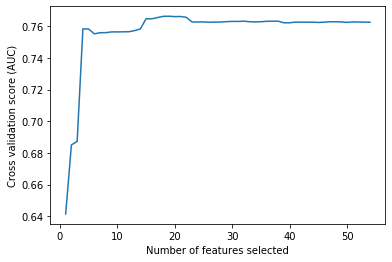

In [0]:
plt.figure()
plt.xlabel('Number of features selected')
plt.ylabel('Cross validation score (AUC)')
plt.plot(range(1,len(rfecv.grid_scores_)+1),rfecv.grid_scores_)
plt.show()

In [0]:
result=pd.DataFrame(var_selected)

In [0]:
result['rfecv_scores']=rfecv.grid_scores_

In [0]:
result.to_csv('selected_variable_astrun.csv')

In [0]:
zmydatatrain.iloc[:, zmydatatrain.columns != 'fraud_label'].columns

Index(['ssn_count0_date', 'ssn_count1_date', 'ssn_count3_date',
       'ssn_count7_date', 'ssn_count14_date', 'ssn_count30_date',
       'ssn_count180_date', 'address_count0_date', 'address_count1_date',
       'address_count3_date',
       ...
       'ssnfulladdress_days_since_last_seen',
       'namehomephone_days_since_last_seen',
       'namefulladdress_days_since_last_seen',
       'fulladdressdob_days_since_last_seen',
       'fulladdresshomephone_days_since_last_seen',
       'fulladdressnamedob_days_since_last_seen',
       'dobhomephone_days_since_last_seen',
       'homephonenamedob_days_since_last_seen', 'dayofweek_risk', 'random'],
      dtype='object', length=306)

In [0]:
wrapper_selected=var_selected[:30]['variable'].to_list()

In [0]:
wrapper_selected.append('fraud_label')

In [0]:
wrapper_selected

['fulladdress_count1_date',
 'fulladdress_count30_date',
 'fulladdress_days_since_last_seen',
 'fulladdress_nunique1_dob',
 'fulladdresshomephone_count30_date',
 'fulladdresshomephone_days_since_last_seen',
 'namedob_count14_date',
 'namedob_count30_date',
 'namedob_days_since_last_seen',
 'ssn_days_since_last_seen',
 'ssndob_count30_date',
 'ssndob_days_since_last_seen',
 'ssnfname_days_since_last_seen',
 'ssnfullname_count30_date',
 'ssnfullname_days_since_last_seen',
 'ssnlname_count30_date',
 'ssnlname_days_since_last_seen',
 'ssnnamedob_count30_date',
 'ssnnamedob_days_since_last_seen',
 'ssnlname_count180_date',
 'fulladdresshomephone_count14_date',
 'fulladdress_nunique3_ssn',
 'address_days_since_last_seen',
 'ssnfname_count14_date',
 'ssnlname_count14_date',
 'ssnfname_count30_date',
 'ssnfullname_count180_date',
 'ssnfname_count180_date',
 'namedob_count180_date',
 'ssnnamedob_count180_date',
 'fraud_label']

### Split zmydatatrain into train and test set:

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [0]:
X_train_copy=pd.read_csv('/content/drive/Shared drives/DSO562 Fraud Project/Project2/Data_Modeling/X_train.csv')
X_test_copy=pd.read_csv('/content/drive/Shared drives/DSO562 Fraud Project/Project2/Data_Modeling/X_test.csv')

In [0]:
X_test=X_test.drop(columns=['Unnamed: 0'])
X_train=X_train.drop(columns=['Unnamed: 0'])

In [0]:
y_test=pd.read_csv('/content/drive/Shared drives/DSO562 Fraud Project/Project2/Data_Modeling/y_test.csv')
y_train=pd.read_csv('/content/drive/Shared drives/DSO562 Fraud Project/Project2/Data_Modeling/y_train.csv')

In [0]:
y_test=y_test['fraud_label']
y_train=y_train['fraud_label']

In [0]:
varall=pd.read_csv('/content/drive/My Drive/Spring 2020/DSO 562 - Fraud Analytics/Project 2/selected_variables.csv')

In [0]:
varall2=pd.read_csv('/content/drive/Shared drives/DSO562 Fraud Project/Project2/selected_variables_version2.csv')

In [0]:
varall=varall2['variable'][:30]

In [0]:
len(varall)

30

In [0]:
variables=varall.to_list()

In [0]:
variables

['fulladdress_count30_date',
 'fulladdress_days_since_last_seen',
 'fulladdress_nunique1_dob',
 'fulladdress_nunique1_ssnfname',
 'fulladdress_nunique3_ssn',
 'fulladdress_nunique3_ssnfname',
 'fulladdresshomephone_count14_date',
 'fulladdresshomephone_count30_date',
 'fulladdresshomephone_days_since_last_seen',
 'namedob_count30_date',
 'namedob_days_since_last_seen',
 'ssn_days_since_last_seen',
 'ssndob_count14_date',
 'ssndob_count30_date',
 'ssndob_days_since_last_seen',
 'ssnfname_days_since_last_seen',
 'ssnfullname_days_since_last_seen',
 'ssnlname_days_since_last_seen',
 'ssnnamedob_count14_date',
 'ssnnamedob_count30_date',
 'ssnnamedob_days_since_last_seen',
 'namedob_count14_date',
 'ssnfname_count180_date',
 'ssnlname_count30_date',
 'ssnfullname_count30_date',
 'ssnfname_count30_date',
 'address_days_since_last_seen',
 'address_count3_date',
 'namedob_count180_date',
 'ssnnamedob_count180_date']

In [0]:
len(variables)

30

In [0]:
X_test=X_test_copy[variables]
X_train=X_train_copy[variables]

In [0]:
#from sklearn.model_selection import train_test_split
#datasplit=zmydatatrain[variables]
#datasplit1 = datasplit.drop("fraud_label", axis = 1)
#X_train, X_test, y_train, y_test = train_test_split(datasplit1, datasplit['fraud_label'], test_size = 0.20, random_state = 9, stratify = datasplit['fraud_label'])

In [0]:
!pip install imblearn

In [0]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1))) 
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0))) 
  
# import SMOTE module from imblearn library 
# pip install imblearn (if you don't have imblearn in your system) 
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state = 2) 
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel()) 
  
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape)) 
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1))) 
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0))) 


Before OverSampling, counts of label '1': 9189
Before OverSampling, counts of label '0': 626807 



/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After OverSampling, the shape of train_X: (1253614, 15)
After OverSampling, the shape of train_y: (1253614,) 

After OverSampling, counts of label '1': 626807
After OverSampling, counts of label '0': 626807


In [0]:
model=LogisticRegression()
model.fit(X_train_res, y_train_res)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
fdrsample=len(model.predict_proba(X_test))*0.03

In [0]:
fdrsample

4770.0

Training Effectiveness

In [0]:
predict=model.predict_proba(X_train)

In [0]:
yactual=y_train.reset_index()
yactual=yactual['fraud_label']

In [0]:
df=pd.DataFrame(predict,yactual)
df=df.reset_index()
df=df.rename(columns={1: 'Pred_Proba'})
predict=df.sort_values('fraud_label',ascending=False)
predict=predict.sort_values('Pred_Proba',ascending=False)
predict.reset_index(inplace=True)

In [0]:
predict=predict.drop(columns=[0,'index'])

In [0]:
predict=predict[:round(len(X_train)*.03)]

In [0]:
predict

,fraud_label,Pred_Proba
0,1,1.000000
1,1,1.000000
2,1,1.000000
3,1,1.000000
4,1,1.000000
...,...,...
19075,0,0.666952
19076,0,0.666952
19077,0,0.666952
19078,0,0.666952


In [0]:
sum(predict['fraud_label']==1)

3254

In [0]:
trainFDR=sum(predict['fraud_label']==1)/(sum(y_train))

Testing with test data:

In [0]:
predict=model.predict_proba(X_test)
yactual=y_test.reset_index()
yactual=yactual['fraud_label']

In [0]:
df=pd.DataFrame(predict,yactual)
df=df.reset_index()
df=df.rename(columns={1: 'Pred_Proba'})
predict=df.sort_values('fraud_label',ascending=False)
predict=predict.sort_values('Pred_Proba',ascending=False)
predict.reset_index(inplace=True)

In [0]:
predict=predict[:round(len(X_test)*.03)]

In [0]:
ytestFDR=sum(predict['fraud_label']==1)/(sum(y_test))

Testing Model:

In [0]:
zmydatatest.shape

(166493, 307)

In [0]:
ztestfraud.shape

(166493,)

In [0]:
datatest=zmydatatest[variables]
ztestfraud=zmydatatest['fraud_label']

In [0]:
predict=model.predict_proba(datatest)

In [0]:
df=pd.DataFrame(predict,ztestfraud)
df=df.reset_index()
df=df.rename(columns={1: 'Pred_Proba'})
predict=df.sort_values('fraud_label',ascending=False)
predict=predict.sort_values('Pred_Proba',ascending=False)
predict.reset_index(inplace=True)

In [0]:
sum(predict[:4995]['fraud_label']==1)

766

In [0]:
sum(predict[:round(len(zmydatatest)*0.03)]['fraud_label']==1)

766

In [0]:
ztestfraud.sum()

2386

In [0]:
ootFDR=sum(predict[:round(len(zmydatatest)*0.03)]['fraud_label']==1)/(sum(ztestfraud))

In [0]:
print(f'The train FDR is: {round(trainFDR*100,4)}%\n\
The test FDR is: {round(ytestFDR*100,4)}%\n\
The oot FDR is: {round(ootFDR*100,4)}%.')

The train FDR is: 35.4119%
The test FDR is: 37.0919%
The oot FDR is: 32.1039%.


In [0]:
predict

,index,fraud_label,0,Pred_Proba
0,162192,0,0.0000,1.0000
1,81816,1,0.0000,1.0000
2,83877,1,0.0000,1.0000
3,83500,1,0.0000,1.0000
4,163870,1,0.0000,1.0000
...,...,...,...,...
166488,9579,0,0.8115,0.1885
166489,120411,0,0.8115,0.1885
166490,94762,0,0.8115,0.1885
166491,33016,0,0.8115,0.1885


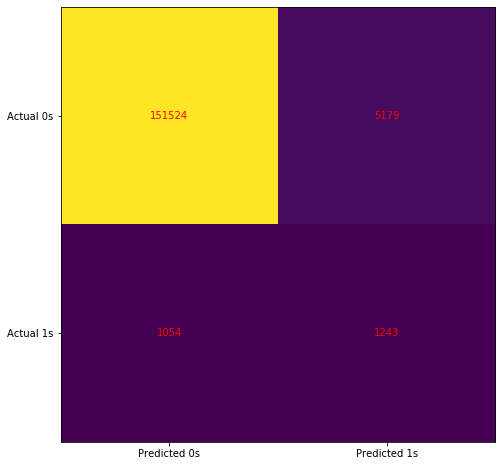

In [0]:
cm = confusion_matrix(y_test, model.predict(X_test))

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

In [0]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98    156703
           1       0.25      0.54      0.34      2297

    accuracy                           0.97    159000
   macro avg       0.62      0.76      0.66    159000
weighted avg       0.98      0.97      0.98    159000



In [0]:
X_train, X_test, y_train, y_test = logitrain_X,logitest_X,logitrain_Y,logitest_Y
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

NameError: ignored

In [0]:
help(LogisticRegression)

In [0]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

In [0]:
y_test

307150    0
613834    0
559776    0
649548    0
529900    0
         ..
528358    0
4668      0
404148    0
440008    0
667359    0
Name: fraud_label, Length: 159000, dtype: int64

##### Decision Tree

In [0]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()

In [0]:
varall2=pd.read_csv('/content/drive/Shared drives/DSO562 Fraud Project/Project2/selected_variables_version2.csv')

In [0]:
varall1=pd.read_csv('/content/drive/Shared drives/DSO562 Fraud Project/Project2/Data_w_top_20_features.csv')
varlist=varall1.columns.to_list()[1:21]

In [0]:
varlist=varall2['variable'][:30].to_list()

In [0]:
varlist=varall2[:30]['variable'].to_list()
varlistcopy=varlist.copy()
varlist.append('fraud_label')

In [0]:
variables=varall2['variable'].to_list()
variables

['fulladdress_count1_date',
 'fulladdress_count30_date',
 'fulladdress_days_since_last_seen',
 'fulladdress_nunique1_dob',
 'fulladdresshomephone_count30_date',
 'fulladdresshomephone_days_since_last_seen',
 'namedob_count14_date',
 'namedob_count30_date',
 'namedob_days_since_last_seen',
 'ssn_days_since_last_seen',
 'ssndob_count30_date',
 'ssndob_days_since_last_seen',
 'ssnfname_days_since_last_seen',
 'ssnfullname_count30_date',
 'ssnfullname_days_since_last_seen',
 'ssnlname_count30_date',
 'ssnlname_days_since_last_seen',
 'ssnnamedob_count30_date',
 'ssnnamedob_days_since_last_seen',
 'ssnlname_count180_date',
 'fulladdresshomephone_count14_date',
 'fulladdress_nunique3_ssn',
 'address_days_since_last_seen',
 'ssnfname_count14_date',
 'ssnlname_count14_date',
 'ssnfname_count30_date',
 'ssnfullname_count180_date',
 'ssnfname_count180_date',
 'namedob_count180_date',
 'ssnnamedob_count180_date',
 'fulladdress_count180_date',
 'address_count30_date',
 'fulladdress_nunique3_dob',


In [0]:
n=30
variables1=variables[:n]
variables1copy=variables[:n]

In [0]:
variables1.append('fraud_label')

In [0]:
variables1=varlist

In [0]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [0]:
from sklearn.model_selection import train_test_split
datasplit=zmydatatrain[varlist]
datasplit1 = datasplit.drop("fraud_label", axis = 1)
X_train, X_test, y_train, y_test = train_test_split(datasplit1, datasplit['fraud_label'], test_size = 0.20, random_state = 11, stratify = datasplit['fraud_label'])

In [0]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1))) 
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0))) 
  
# import SMOTE module from imblearn library 
# pip install imblearn (if you don't have imblearn in your system) 
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state = 2) 
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel()) 
  
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape)) 
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1))) 
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0))) 


Before OverSampling, counts of label '1': 9189
Before OverSampling, counts of label '0': 626807 



/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After OverSampling, the shape of train_X: (1253614, 20)
After OverSampling, the shape of train_y: (1253614,) 

After OverSampling, counts of label '1': 626807
After OverSampling, counts of label '0': 626807


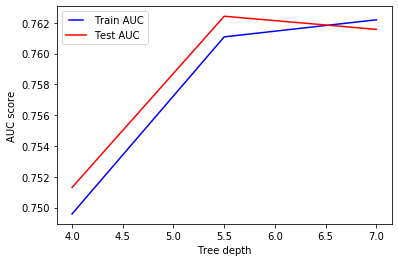

In [0]:
max_depths = np.linspace(4, 7, 3, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   dt = DecisionTreeClassifier(max_depth=max_depth)
   dt.fit(X_train_res, y_train_res)
   train_pred = dt.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous train results
   train_results.append(roc_auc)
   y_pred = dt.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous test results
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()
# Max Depth best parameter should be 5.5

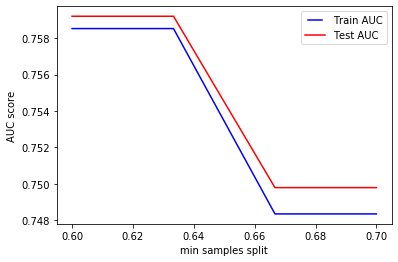

In [0]:
min_samples_splits = np.linspace(0.6, 0.7,4, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
   dt = DecisionTreeClassifier(max_depth=5.5,min_samples_split=min_samples_split)
   dt.fit(X_train_res, y_train_res)
   train_pred = dt.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds =    roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = dt.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results, 'b', label="Train AUC")
line2, = plt.plot(min_samples_splits, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples split')
plt.show()
## Min_Samples_Splits=0.67

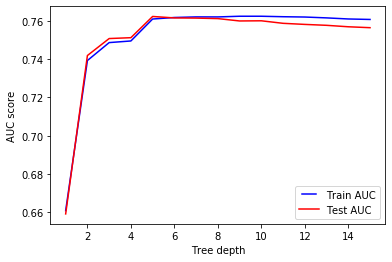

In [0]:
max_depths = np.linspace(1, 15, 15, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   dt = DecisionTreeClassifier(max_depth=max_depth)
   dt.fit(X_train_res, y_train_res)
   train_pred = dt.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous train results
   train_results.append(roc_auc)
   y_pred = dt.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous test results
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("Tree depth")
plt.show()

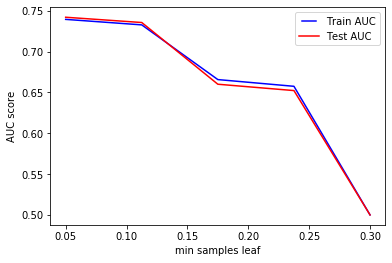

In [0]:
min_samples_leafs = np.linspace(0.05, 0.3, 5, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
   dt = DecisionTreeClassifier(max_depth=5.5,min_samples_split=0.67,min_samples_leaf=min_samples_leaf)
   dt.fit(X_train_res, y_train_res)
   train_pred = dt.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = dt.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_leafs, train_results, 'b', label="Train AUC")
line2, = plt.plot(min_samples_leafs, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples leaf')
plt.show()
## Min_Samples 0.2

In [0]:
clf=DecisionTreeClassifier(max_depth=6,min_samples_split=0.625)
from sklearn.metrics import confusion_matrix

In [0]:
from sklearn.model_selection import train_test_split
datasplit=zmydatatrain[varlist]
datasplit1 = datasplit.drop("fraud_label", axis = 1)
X_train, X_test, y_train, y_test = train_test_split(datasplit1, datasplit['fraud_label'], test_size = 0.20, random_state = 59, stratify = datasplit['fraud_label'])

In [0]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1))) 
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0))) 
  
# import SMOTE module from imblearn library 
# pip install imblearn (if you don't have imblearn in your system) 
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state = 2) 
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel()) 
  
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape)) 
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1))) 
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0))) 


Before OverSampling, counts of label '1': 9189
Before OverSampling, counts of label '0': 626807 



/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After OverSampling, the shape of train_X: (1253614, 30)
After OverSampling, the shape of train_y: (1253614,) 

After OverSampling, counts of label '1': 626807
After OverSampling, counts of label '0': 626807


In [0]:
X_train_sub=X_train_res
clf.fit(X_train_res, y_train_res)
prediction_train = clf.predict(X_train_sub)
matrix = confusion_matrix(y_train_res, prediction_train)
train_acc = clf.score(X_train_sub, y_train_res)
train_auc = roc_auc_score(y_train_res, prediction_train)
train_fdr = matrix[1,1]/sum(y_train_res)

In [0]:
temp=pd.DataFrame()

In [0]:
varlist

['fulladdress_count1_date',
 'fulladdress_count30_date',
 'fulladdress_days_since_last_seen',
 'fulladdress_nunique1_dob',
 'fulladdresshomephone_count30_date',
 'fulladdresshomephone_days_since_last_seen',
 'namedob_count14_date',
 'namedob_count30_date',
 'namedob_days_since_last_seen',
 'ssn_days_since_last_seen',
 'ssndob_count30_date',
 'ssndob_days_since_last_seen',
 'ssnfname_days_since_last_seen',
 'ssnfullname_count30_date',
 'ssnfullname_days_since_last_seen',
 'ssnlname_count30_date',
 'ssnlname_days_since_last_seen',
 'ssnnamedob_count30_date',
 'ssnnamedob_days_since_last_seen',
 'ssnlname_count180_date',
 'fulladdresshomephone_count14_date',
 'fulladdress_nunique3_ssn',
 'address_days_since_last_seen',
 'ssnfname_count14_date',
 'ssnlname_count14_date',
 'ssnfname_count30_date',
 'ssnfullname_count180_date',
 'ssnfname_count180_date',
 'namedob_count180_date',
 'ssnnamedob_count180_date',
 'fraud_label']

In [0]:
X_test_sub = X_test[varlist[:30]]
prediction_test = clf.predict_proba(X_test_sub)[:,1]
temp=pd.DataFrame(prediction_test,y_test)

In [0]:
temp.reset_index(inplace=True)

In [0]:
temp=temp.sort_values(0,ascending=False)

In [0]:
testFDRdt=sum(temp[:round(len(temp)*0.03)]['fraud_label']==1)/sum(y_test)

In [0]:
print(f'The testing FDR at 3% is {testFDRdt}.')

The testing FDR at 3% is 0.543317370483239.


In [0]:
#matrix = confusion_matrix(y_test, prediction_test)
#test_acc = clf.score(X_test_sub, y_test)
#test_auc = roc_auc_score(y_test, prediction_test)
#test_fdr = matrix[1,1]/sum(y_test)
#comparison_df = pd.DataFrame({ "Accuracy": [train_acc, test_acc],
                                  #"AUC score": [train_auc, test_auc],
                                  #"FDR": [train_fdr, test_fdr]},
                                 #index = ["Training", "Testing"])

In [0]:
prediction_train=clf.predict_proba(X_train)[:,1]
temp=pd.DataFrame(prediction_train,y_train)
temp.reset_index(inplace=True)
temp

,fraud_label,0
0,0,0.327777
1,0,0.327777
2,0,0.327777
3,0,0.327777
4,0,0.327777
...,...,...
635991,0,0.327777
635992,0,0.327777
635993,0,0.327777
635994,0,0.327777


In [0]:
temp=temp.sort_values(0,ascending=False)
temp1=temp[:round(len(temp)*0.03)]
trainFDRdt=temp1['fraud_label'].sum()/(temp['fraud_label'].sum())
print(f'The training FDR at 3% is {trainFDRdt}.')

The training FDR at 3% is 0.5361845685058222.


In [0]:
temp1['fraud_label'].sum()

4927

In [0]:
temp['fraud_label'].sum()

9189

##### Testing with OOT Data

In [0]:
datatest=zmydatatest[varlist[:30]]
ztestfraud=zmydatatest['fraud_label']
predict=clf.predict_proba(datatest)[:,1]
temp=pd.DataFrame(predict,ztestfraud).reset_index()

In [0]:
temp=temp.sort_values(0,ascending=False)
temp=temp[:round(len(temp)*0.03)]
ootfdrdt=temp['fraud_label'].sum()/zmydatatest['fraud_label'].sum()

In [0]:
print(f'The train FDR for decision tree is: {round(trainFDRdt*100,4)}%\n\
The test FDR for decision tree is: {round(testFDRdt*100,4)}%\n\
The oot FDR for decision tree is: {round(ootfdrdt*100,4)}%.')

The train FDR for decision tree is: 53.6185%
The test FDR for decision tree is: 54.3317%
The oot FDR for decision tree is: 50.5029%.


In [0]:
len(varlist)

31

#### NeuroNet (1):

In [0]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

In [0]:
varlist=varall2[:30]['variable'].to_list()
varlist.append('fraud_label')
varlist

['fulladdress_count1_date',
 'fulladdress_count30_date',
 'fulladdress_days_since_last_seen',
 'fulladdress_nunique1_dob',
 'fulladdresshomephone_count30_date',
 'fulladdresshomephone_days_since_last_seen',
 'namedob_count14_date',
 'namedob_count30_date',
 'namedob_days_since_last_seen',
 'ssn_days_since_last_seen',
 'ssndob_count30_date',
 'ssndob_days_since_last_seen',
 'ssnfname_days_since_last_seen',
 'ssnfullname_count30_date',
 'ssnfullname_days_since_last_seen',
 'ssnlname_count30_date',
 'ssnlname_days_since_last_seen',
 'ssnnamedob_count30_date',
 'ssnnamedob_days_since_last_seen',
 'ssnlname_count180_date',
 'fulladdresshomephone_count14_date',
 'fulladdress_nunique3_ssn',
 'address_days_since_last_seen',
 'ssnfname_count14_date',
 'ssnlname_count14_date',
 'ssnfname_count30_date',
 'ssnfullname_count180_date',
 'ssnfname_count180_date',
 'namedob_count180_date',
 'ssnnamedob_count180_date',
 'fraud_label']

In [0]:
varlist=varall2[:30]['variable'].to_list()
varlistcopy=varall2[:30]['variable'].to_list()
#varlistcopy=varlist.copy()
#varlist.append('fraud_label')

In [0]:
varlist.append('fraud_label')

In [0]:
parameters = {'solver': ['lbfgs'], 'max_iter': [500,1000,1500], 'alpha': 10.0 ** -np.arange(1, 7), 'hidden_layer_sizes':np.arange(5, 12), 'random_state':[0,1,2,3,4,5,6,7,8,9]}
clf_grid_hair_soul = GridSearchCV(neural_network.MLPClassifier(), parameters, n_jobs=-1)

In [0]:
clf =MLPClassifier(hidden_layer_sizes=(15,15,15), max_iter = 1500,solver='sgd',learning_rate_init=0.001,random_state=8)

In [0]:
from sklearn.model_selection import train_test_split
datasplit=zmydatatrain[varlist]
datasplit1 = datasplit.drop("fraud_label", axis = 1)
X_train, X_test, y_train, y_test = train_test_split(datasplit1, datasplit['fraud_label'], test_size = 0.20, random_state = 10, stratify = datasplit['fraud_label'])

In [0]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1))) 
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0))) 
  
# import SMOTE module from imblearn library 
# pip install imblearn (if you don't have imblearn in your system) 
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state = 2) 
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel()) 
  
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape)) 
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1))) 
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0))) 


Before OverSampling, counts of label '1': 9189
Before OverSampling, counts of label '0': 626807 



/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After OverSampling, the shape of train_X: (1253614, 30)
After OverSampling, the shape of train_y: (1253614,) 

After OverSampling, counts of label '1': 626807
After OverSampling, counts of label '0': 626807


In [0]:
X_train_sub = X_train_res
clf.fit(X_train_sub, y_train_res)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(15, 15, 15), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=8, shuffle=True, solver='sgd',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [0]:
prediction_train = clf.predict(X_train_sub)
matrix = confusion_matrix(y_train_res, prediction_train)
train_acc = clf.score(X_train_sub, y_train_res)
train_auc = roc_auc_score(y_train_res, prediction_train)
train_fdr = matrix[1,1]/sum(y_train_res)

In [0]:
len(varlist)

31

In [0]:
n=30
temp=pd.DataFrame()
X_test_sub = X_test[varlist[:n]]
prediction_test = clf.predict_proba(X_test_sub)[:,1]
temp=pd.DataFrame(prediction_test,y_test)
temp.reset_index(inplace=True)
temp=temp.sort_values(0,ascending=False)

In [0]:
testFDRnn=sum(temp[:round(len(temp)*0.03)]['fraud_label']==1)/sum(y_test)
print(f'The testing FDR at 3% is {testFDRnn}.')

The testing FDR at 3% is 0.5454941227688289.


In [0]:
prediction_train=clf.predict_proba(X_train)[:,1]
temp=pd.DataFrame(prediction_train,y_train)
temp.reset_index(inplace=True)
temp=temp.sort_values(0,ascending=False)

In [0]:
temp['fraud_label'].sum()

9189

In [0]:

temp1=temp[:round(len(temp)*0.03)]
trainFDRnn=temp1['fraud_label'].sum()/(temp['fraud_label'].sum())
print(f'The training FDR at 3% is {trainFDRnn}.')

The training FDR at 3% is 0.5430405920121885.


In [0]:
datatest=zmydatatest[varlistcopy]
ztestfraud=zmydatatest['fraud_label']
predict=clf.predict_proba(datatest)[:,1]
temp=pd.DataFrame(predict,ztestfraud).reset_index()
temp=temp.sort_values(0,ascending=False)

In [0]:

temp=temp[:round(len(temp)*0.03)]
ootfdrnn=temp['fraud_label'].sum()/zmydatatest['fraud_label'].sum()

In [0]:
print(f'The train FDR for decision tree is: {round(trainFDRnn*100,4)}%\n\
The test FDR for decision tree is: {round(testFDRnn*100,4)}%\n\
The oot FDR for decision tree is: {round(ootfdrnn*100,4)}%.')

The train FDR for decision tree is: 54.3041%
The test FDR for decision tree is: 54.5494%
The oot FDR for decision tree is: 52.7661%.


In [0]:
import numpy as np
int(len(X_train)*0.03)

19079

In [0]:
slicer=list(range(0,34964,1665))
final=[]
for i in range(1,len(slicer)):
  begin=slicer[i-1]
  end=slicer[i]
  result=sum(temp[begin:end]['fraud_label'])
  final.append([slicer[i],result])


In [0]:
final

[[1665, 1172],
 [3330, 71],
 [4995, 16],
 [6660, 0],
 [8325, 0],
 [9990, 0],
 [11655, 0],
 [13320, 0],
 [14985, 0],
 [16650, 0],
 [18315, 0],
 [19980, 0],
 [21645, 0],
 [23310, 0],
 [24975, 0],
 [26640, 0],
 [28305, 0],
 [29970, 0],
 [31635, 0],
 [33300, 0]]

In [0]:
temp['fraud_label'].sum()

1259